# 1) Setup drive and import modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
from google.colab import drive
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive.mount('/gdrive')
!ls /gdrive

BASE_PATH = '/gdrive/My Drive/colab_files/aux-net/'
DATA_PATH = BASE_PATH + 'data'

Mounted at /gdrive
MyDrive  Shareddrives


# 2) Upload and process dataset

In [2]:
import numpy as np
import torchvision
import torchvision.transforms as transforms


def upload_data(path):
    '''
    Inputs in data are motor positions [m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11]
    Out positions [x_top (0), y_top (1), z_top (2), qx_top (3), qy_top (4), qz_top (5), qw_top (6)
                   x_mid (7), y_mid (8), z_mid (9), qx_mid (10), qy_mid (11), qz_mid (12), qw_mid (13)
                   x_end (14), y_end (15), z_end (16), qx_end (17), qy_end (18), qz_end (19), qw_end (20)]
    '''
    data = np.loadtxt(path, skiprows = 1, delimiter=',',dtype = 'float32')
        
    # Split into randomized 80/20 train test
    np.random.seed(8) 
    np.random.shuffle(data)
    n = np.size(data,0)

    train_set = data[0:int(n*.8),:]
    test_set = data[int(n*.8):n,:]

    # Set up data loader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32)

    return {'train': train_loader, 'test': test_loader, 'train_set' : train_set, 'test_set' : test_set}

# 3) Define different network architecture

In [3]:
class aux_net(nn.Module):
    def __init__(self, inputs=12, hidden=256, outputs=21):
        super(aux_net, self).__init__()
        self.fc1 = nn.Linear(inputs,hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,outputs)
        self.input_size = inputs
        self.output_size = outputs

    def forward(self,x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class aux_net_tip(nn.Module):
    def __init__(self, inputs=12, hidden=1024, outputs=3):
        super(aux_net_tip, self).__init__()
        self.fc1 = nn.Linear(inputs,hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,outputs)
        self.input_size = inputs
        self.output_size = outputs

    def forward(self,x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Define training function

In [4]:
import torch.optim as optim

def train(net, train_loader, epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,metric='entire'):
    net.to(device)
    losses = []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr, weight_decay=decay)
    for epoch in range(epochs):
        sum_loss = 0
        loss_list = []
        if epoch % 10 == 9:
            lr = lr / 4
        for i, batch in enumerate(train_loader,0):
            # Split the data into motor inputs and measure pose outputs
            x, y_measured = batch[:,0:net.input_size].to(device), batch[:,net.input_size:].to(device)
            
            # Trim data to just measured
            if metric == 'tip':
                y_measured = y_measured[:,14:17]

            # Reset gradients
            optimizer.zero_grad()

            # Run network forward, backward, and then update
            y_pred = net(x)
            loss = criterion(y_pred,y_measured)
            loss.backward()
            optimizer.step()

            # Track performance
            loss_list.append(loss.item())
            sum_loss += loss.item()
            if i % 100 == 99:
                if verbose:
                    print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0
        losses.append(np.mean(loss_list))
        loss_list = []
    return losses

# Find accuracy of final end effector positions (X,Y,Z)
def test(net,test_loader,metric='entire'):
    accuracy = []
    err = np.array([])
    for batch in test_loader:
        x, y_measured = batch[:,0:net.input_size].to(device), batch[:,net.input_size:].to(device)
        y_pred = net(x)
        # Calculate error for just the end-effector
        if metric == 'entire':
            e = y_pred.numpy(force=True)[:,14:17]-y_measured.numpy(force=True)[:,14:17]
        elif metric == 'tip':
            e = y_pred.numpy(force=True)-y_measured.numpy(force=True)[:,14:17]
        # error = np.sqrt(np.mean(e**2,axis=1)).flatten()
        error = np.linalg.norm(e,axis = 1).flatten()
        accuracy.append(np.mean(error))
        err = np.append(err,error)
    return np.mean(accuracy), err

# Data Vis and Evaluation

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def eval_model(net,train_loss,invert_zy = False):

    # Plot losses during training
    f = plt.figure()
    f.set_size_inches(20,5)
    ax1 = f.add_subplot(1,3,1)
    ax2 = f.add_subplot(1,3,2)
    ax3 = f.add_subplot(1,3,3,projection='3d')

    # Plot training loss
    ax1.plot(train_loss,linewidth = 2)
    ax1.set_xlabel("Epochs",fontsize = 14)
    ax1.set_ylabel("Loss",fontsize = 14)
    ax1.set_title("Train Loss",fontsize = 16)
    ax1.grid()


    # Determine train and test accuracy
    test_accuracy,test_error = test(net,data['test'],metric='tip')
    train_accuracy, train_error = test(net,data['train'],metric='tip')

    # Convert all units
    test_accuracy *= 1000
    test_error = test_error*1000
    train_accuracy *= 1000
    train_error = train_error*1000

    print("Train accuracy {:.10f} mm Test accuracy: {:.10f} mm".format(train_accuracy,test_accuracy))

    # Show testing accuracy
    ax2.hist(test_error,20)
    ax2.set_xlabel("Error (mm)",fontsize = 14)
    ax2.set_ylabel("Count",fontsize = 14)
    ax2.set_title("Positional Error for Test Data",fontsize = 16)
    ax2.grid()

    # Show where errors occur in the workspace
    x = 1000*data['test_set'][:,14+12]
    y = 1000*data['test_set'][:,15+12]
    z = 1000*data['test_set'][:,16+12]

    if invert_zy:
        y_n = z
        z_n = y
        y = y_n
        z = z_n

    p = ax3.scatter(x, y, z, c=test_error, cmap=plt.cm.jet,vmin=0,vmax=0.65*np.max(test_error))
    ax3.view_init(45, 45)
    cb = f.colorbar(p)
    cb.set_label("Error (mm)")
    ax3.set_xlabel("xe",fontsize = 14)
    ax3.set_ylabel("ye",fontsize = 14)
    ax3.set_zlabel("ze",fontsize = 14)
    ax3.set_zlim3d(min(z)-5,max(z)+5)
    ax3.set_title("Aux-Net Prediction Accuracy",fontsize = 16)
    ax3.grid()

    plt.tight_layout()
    plt.show()

# Train network (V0)


In [39]:
from matplotlib import pyplot as plt

# Constants for model
BATCH_SIZE= 16
EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# Setup for training
data = upload_data(DATA_PATH + '/32000_dataset.csv')
net_tip = aux_net_tip(hidden=256)

# Train model
train_loss = train(net_tip,data['train'],EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,metric='tip')

# Save model
torch.save(net_tip,BASE_PATH+'/models/net_0')

(Epoch 1, Iter 100) loss: 3.075037
(Epoch 1, Iter 200) loss: 0.010117
(Epoch 1, Iter 300) loss: 0.005036
(Epoch 1, Iter 400) loss: 0.003331
(Epoch 1, Iter 500) loss: 0.003181
(Epoch 1, Iter 600) loss: 0.007890
(Epoch 1, Iter 700) loss: 0.004011
(Epoch 1, Iter 800) loss: 0.004414
(Epoch 1, Iter 900) loss: 0.020578
(Epoch 2, Iter 100) loss: 0.014046
(Epoch 2, Iter 200) loss: 0.020767
(Epoch 2, Iter 300) loss: 0.148102
(Epoch 2, Iter 400) loss: 0.003066
(Epoch 2, Iter 500) loss: 0.015353
(Epoch 2, Iter 600) loss: 0.003709
(Epoch 2, Iter 700) loss: 0.015828
(Epoch 2, Iter 800) loss: 0.007648
(Epoch 2, Iter 900) loss: 0.025726
(Epoch 3, Iter 100) loss: 0.004595
(Epoch 3, Iter 200) loss: 0.013218
(Epoch 3, Iter 300) loss: 0.006147
(Epoch 3, Iter 400) loss: 0.010227
(Epoch 3, Iter 500) loss: 0.013640
(Epoch 3, Iter 600) loss: 0.008075
(Epoch 3, Iter 700) loss: 0.027094
(Epoch 3, Iter 800) loss: 0.002880
(Epoch 3, Iter 900) loss: 0.026628
(Epoch 4, Iter 100) loss: 0.022813
(Epoch 4, Iter 200) 

# Results

Train accuracy 3.3572821412 mm Test accuracy: 3.3529005013 mm


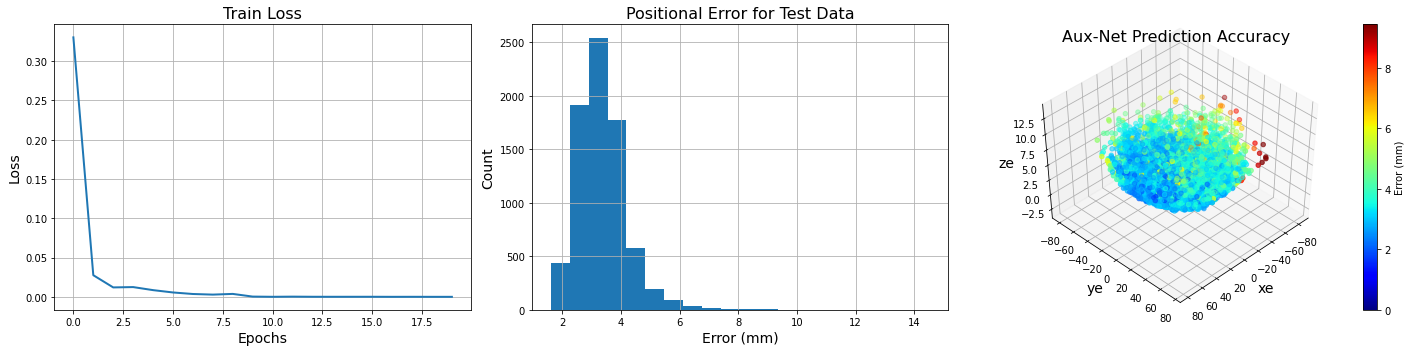

In [40]:
eval_model(net_tip,train_loss,invert_zy=False)

# Train network (V1)
Decrease learning rate (0.001 -> 0.0005)

In [41]:
from matplotlib import pyplot as plt

# Constants for model
BATCH_SIZE= 16
EPOCHS = 20
LEARNING_RATE = 0.0005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# Setup for training
data = upload_data(DATA_PATH + '/32000_dataset.csv')
net_tip = aux_net_tip(hidden=256)

# Train model
train_loss = train(net_tip,data['train'],EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,metric='tip')

# Save model
torch.save(net_tip,BASE_PATH+'/models/net_1')

(Epoch 1, Iter 100) loss: 1.160072
(Epoch 1, Iter 200) loss: 0.010825
(Epoch 1, Iter 300) loss: 0.007140
(Epoch 1, Iter 400) loss: 0.004151
(Epoch 1, Iter 500) loss: 0.005378
(Epoch 1, Iter 600) loss: 0.018129
(Epoch 1, Iter 700) loss: 0.026830
(Epoch 1, Iter 800) loss: 0.004683
(Epoch 1, Iter 900) loss: 0.008676
(Epoch 2, Iter 100) loss: 0.015575
(Epoch 2, Iter 200) loss: 0.047942
(Epoch 2, Iter 300) loss: 0.007746
(Epoch 2, Iter 400) loss: 0.008032
(Epoch 2, Iter 500) loss: 0.011209
(Epoch 2, Iter 600) loss: 0.024777
(Epoch 2, Iter 700) loss: 0.007786
(Epoch 2, Iter 800) loss: 0.016142
(Epoch 2, Iter 900) loss: 0.019349
(Epoch 3, Iter 100) loss: 0.016481
(Epoch 3, Iter 200) loss: 0.011722
(Epoch 3, Iter 300) loss: 0.024755
(Epoch 3, Iter 400) loss: 0.014885
(Epoch 3, Iter 500) loss: 0.052613
(Epoch 3, Iter 600) loss: 0.002365
(Epoch 3, Iter 700) loss: 0.004895
(Epoch 3, Iter 800) loss: 0.009562
(Epoch 3, Iter 900) loss: 0.012883
(Epoch 4, Iter 100) loss: 0.038087
(Epoch 4, Iter 200) 

# Results

Train accuracy 4.4844397344 mm Test accuracy: 4.4705667533 mm


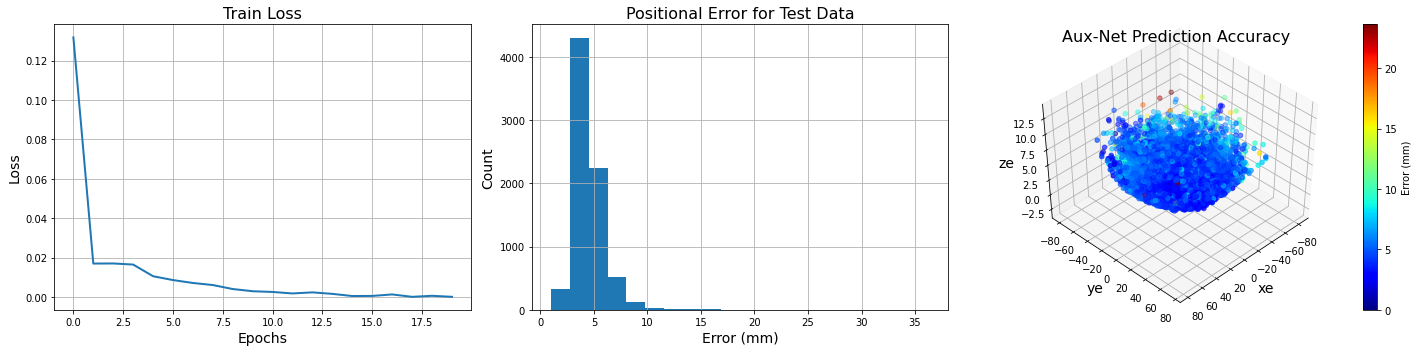

In [42]:
eval_model(net_tip,train_loss,invert_zy=False)

# Train network (V3)
Increase number of epochs

In [43]:
from matplotlib import pyplot as plt

# Constants for model
BATCH_SIZE= 16
EPOCHS = 30
LEARNING_RATE = 0.0005
MOMENTUM = .01
WEIGHT_DECAY = 0.0005

# Setup for training
data = upload_data(DATA_PATH + '/32000_dataset.csv')
net_tip = aux_net_tip(hidden=512)

# Train model
train_loss = train(net_tip,data['train'],EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,metric='tip')

# Save model
torch.save(net_tip,BASE_PATH+'/models/net_3')

(Epoch 1, Iter 100) loss: 6.426903
(Epoch 1, Iter 200) loss: 0.005738
(Epoch 1, Iter 300) loss: 0.015746
(Epoch 1, Iter 400) loss: 0.051801
(Epoch 1, Iter 500) loss: 0.013082
(Epoch 1, Iter 600) loss: 0.050121
(Epoch 1, Iter 700) loss: 0.106353
(Epoch 1, Iter 800) loss: 0.015577
(Epoch 1, Iter 900) loss: 0.122942
(Epoch 2, Iter 100) loss: 0.049794
(Epoch 2, Iter 200) loss: 0.057899
(Epoch 2, Iter 300) loss: 0.103183
(Epoch 2, Iter 400) loss: 0.029459
(Epoch 2, Iter 500) loss: 0.064636
(Epoch 2, Iter 600) loss: 0.043610
(Epoch 2, Iter 700) loss: 0.066661
(Epoch 2, Iter 800) loss: 0.073362
(Epoch 2, Iter 900) loss: 0.063157
(Epoch 3, Iter 100) loss: 0.076335
(Epoch 3, Iter 200) loss: 0.045732
(Epoch 3, Iter 300) loss: 0.066225
(Epoch 3, Iter 400) loss: 0.030966
(Epoch 3, Iter 500) loss: 0.067348
(Epoch 3, Iter 600) loss: 0.061248
(Epoch 3, Iter 700) loss: 0.058545
(Epoch 3, Iter 800) loss: 0.244652
(Epoch 3, Iter 900) loss: 0.025011
(Epoch 4, Iter 100) loss: 0.022209
(Epoch 4, Iter 200) 

# Results

Train accuracy 3.1356469262 mm Test accuracy: 3.1422406901 mm


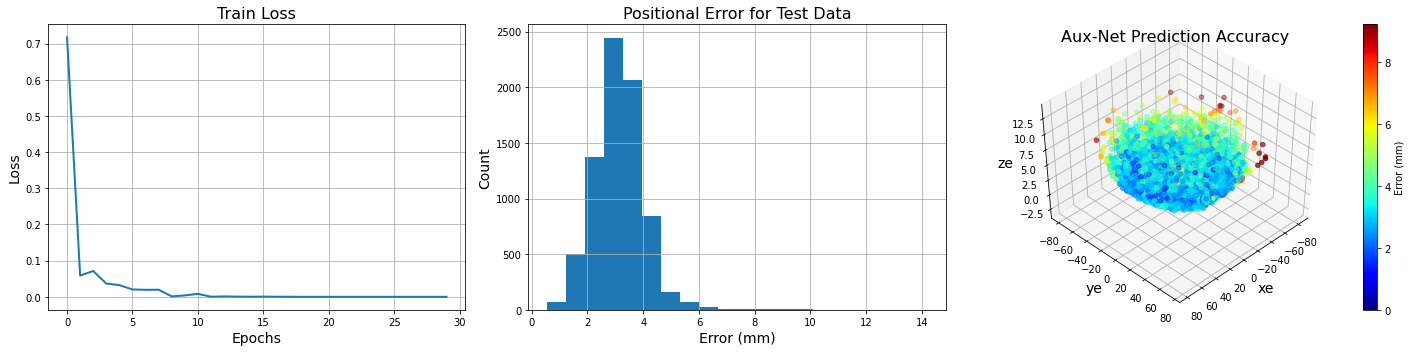

In [44]:
eval_model(net_tip,train_loss,invert_zy=False)

# Train network (V4)

Change learning rate back to 0.001 but decrease momentum


In [45]:
from matplotlib import pyplot as plt

# Constants for model
BATCH_SIZE= 16
EPOCHS = 30
LEARNING_RATE = 0.001
MOMENTUM = .2
WEIGHT_DECAY = 0.0005

# Setup for training
data = upload_data(DATA_PATH + '/32000_dataset.csv')
net_tip = aux_net_tip(hidden=256)

# Train model
train_loss = train(net_tip,data['train'],EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,metric='tip')

# Save model
torch.save(net_tip,BASE_PATH+'/models/net_4')

(Epoch 1, Iter 100) loss: 2.891461
(Epoch 1, Iter 200) loss: 0.007767
(Epoch 1, Iter 300) loss: 0.005085
(Epoch 1, Iter 400) loss: 0.003270
(Epoch 1, Iter 500) loss: 0.010351
(Epoch 1, Iter 600) loss: 0.031324
(Epoch 1, Iter 700) loss: 0.015668
(Epoch 1, Iter 800) loss: 0.007851
(Epoch 1, Iter 900) loss: 0.028632
(Epoch 2, Iter 100) loss: 0.016751
(Epoch 2, Iter 200) loss: 0.024442
(Epoch 2, Iter 300) loss: 0.017019
(Epoch 2, Iter 400) loss: 0.020093
(Epoch 2, Iter 500) loss: 0.022034
(Epoch 2, Iter 600) loss: 0.015011
(Epoch 2, Iter 700) loss: 0.027868
(Epoch 2, Iter 800) loss: 0.005400
(Epoch 2, Iter 900) loss: 0.025421
(Epoch 3, Iter 100) loss: 0.005393
(Epoch 3, Iter 200) loss: 0.040672
(Epoch 3, Iter 300) loss: 0.002730
(Epoch 3, Iter 400) loss: 0.006756
(Epoch 3, Iter 500) loss: 0.013946
(Epoch 3, Iter 600) loss: 0.012085
(Epoch 3, Iter 700) loss: 0.015326
(Epoch 3, Iter 800) loss: 0.014814
(Epoch 3, Iter 900) loss: 0.011309
(Epoch 4, Iter 100) loss: 0.016593
(Epoch 4, Iter 200) 

# Results

Train accuracy 2.2689166944 mm Test accuracy: 2.2694969084 mm


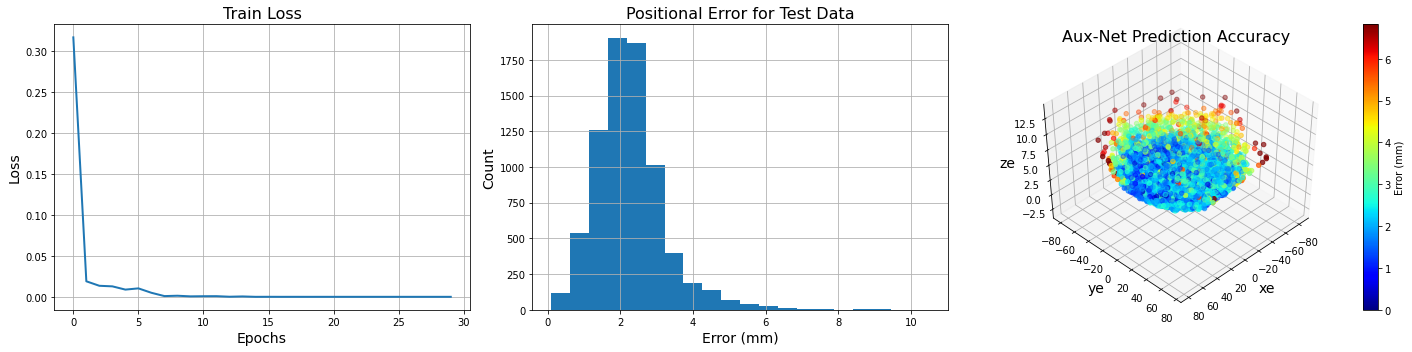

In [46]:
eval_model(net_tip,train_loss,invert_zy=False)

# Train Network (V5)
Further Decrease hidden layer size and increase momentum

In [73]:
from matplotlib import pyplot as plt

# Constants for model
BATCH_SIZE= 16
EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = .9
WEIGHT_DECAY = 0.0005

# Setup for training
data = upload_data(DATA_PATH + '/32000_dataset.csv')
net_tip = aux_net_tip(hidden=512)

# Train model
train_loss = train(net_tip,data['train'],EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,metric='tip')

# Save model
torch.save(net_tip,BASE_PATH+'/models/net_4')

(Epoch 1, Iter 100) loss: 22.590318
(Epoch 1, Iter 200) loss: 0.008862
(Epoch 1, Iter 300) loss: 0.007264
(Epoch 1, Iter 400) loss: 0.004245
(Epoch 1, Iter 500) loss: 0.002664
(Epoch 1, Iter 600) loss: 0.002891
(Epoch 1, Iter 700) loss: 0.007983
(Epoch 1, Iter 800) loss: 0.007641
(Epoch 1, Iter 900) loss: 0.065423
(Epoch 2, Iter 100) loss: 0.079962
(Epoch 2, Iter 200) loss: 0.001821
(Epoch 2, Iter 300) loss: 0.004340
(Epoch 2, Iter 400) loss: 0.001543
(Epoch 2, Iter 500) loss: 0.004816
(Epoch 2, Iter 600) loss: 0.055553
(Epoch 2, Iter 700) loss: 0.009475
(Epoch 2, Iter 800) loss: 0.034686
(Epoch 2, Iter 900) loss: 0.037720
(Epoch 3, Iter 100) loss: 0.041938
(Epoch 3, Iter 200) loss: 0.055972
(Epoch 3, Iter 300) loss: 0.032790
(Epoch 3, Iter 400) loss: 0.081779
(Epoch 3, Iter 500) loss: 0.009275
(Epoch 3, Iter 600) loss: 0.024654
(Epoch 3, Iter 700) loss: 0.029010
(Epoch 3, Iter 800) loss: 0.008458
(Epoch 3, Iter 900) loss: 0.056585
(Epoch 4, Iter 100) loss: 0.004537
(Epoch 4, Iter 200)

# Results

Train accuracy 2.7156332508 mm Test accuracy: 2.6860998478 mm


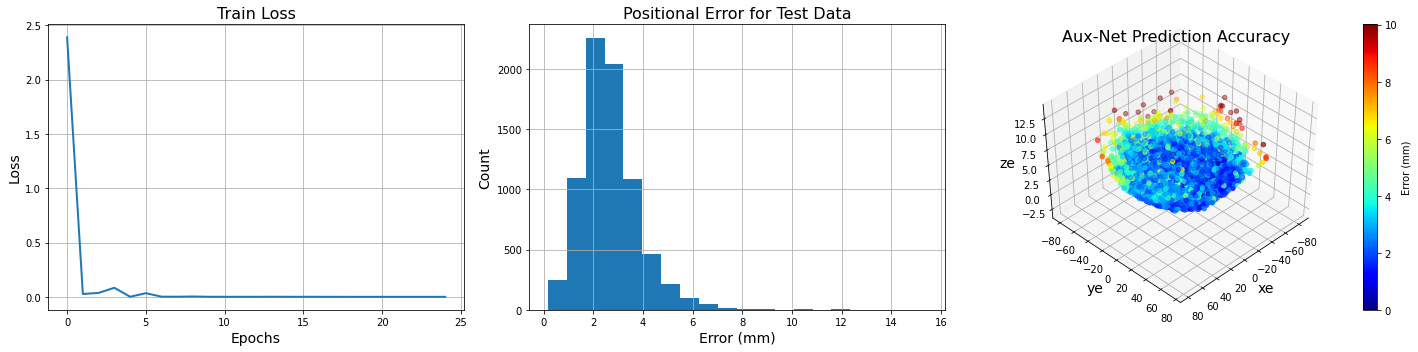

In [74]:
eval_model(net_tip,train_loss,invert_zy=False)